In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import actionability, re
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from IPython.display import Image

We grouped the ratings from the original data set by URL (equivalently, by unit ID):

In [2]:
raw_action_df = pd.read_csv('../data/actionability.csv', index_col='_unit_id', encoding='utf-8')

In [3]:
print raw_action_df.iloc[0]

action                                               ListenAction
action_inst     ListenAction: Does the web page offer you the ...
actionrating                                                   13
rating_count                                                   15
action_pct                                              0.8666667
domain                                                   rdio.com
site            http://www.rdio.com/browse/?ppKey=stations&ppS...
html            <!DOCTYPE html>\n<html>\n  <head>\n    \n    \...
Name: 716816295, dtype: object


The column <code>html</code> is the HTML source of the webpage as obtained with the library <code>requests</code>.

The column <code>actionrating</code> gives the number of "Yes" ratings for that URL, and <code>rating_count</code> is the total number of ratings. We take the ratio of these and call it <code>action_pct</code>. Ideally this figure should be 1 or 0, indicating that all users agreed on the (non)actionability of the page; a value of <code>action_pct</code> near 0.5 indicates a lack of consensus on that item. We therefore exclude those webpages whose <code>action_pct</code> is within 0.1 of 0.5.

In [4]:
action_df = raw_action_df[raw_action_df.action_pct.apply(lambda x:abs(x-0.5)) > 0.1].copy()

This leaves us with about 80% of the original data:

In [5]:
len(action_df)*1.0/len(raw_action_df)

0.7984496124031008

For classification purposes, we will say that a webpage is *actionable* if it has <code>action_pct > 0.5</code>:

In [6]:
action_df['is_actionable'] = (action_df.action_pct > 0.5)

Now let's construct some numerical features. By *token* we mean here a string of Latin letters. Using <code>lxml</code> we parse each HTML file and extract the tokens from all link texts and the tokens from all button texts, all converted to lowercase. We call these *clickable tokens*. The methods to do this are found in <code>actionability.py</code>.

In [7]:
action_df['link_text_token_string'] = action_df.html.apply(actionability.html_to_link_text_token_string)
action_df['button_name_token_string'] = action_df.html.apply(actionability.html_to_button_name_token_string)
action_df['clickable_tokens'] = action_df.link_text_token_string + ' ' + action_df.button_name_token_string

In [8]:
action_df.clickable_tokens.head()

_unit_id
716816295                                                     
716817011    free trial music apps devices pricing listen n...
716817012    subscribe to our rss feed follow us on twitter...
716817013    subscribe to our rss feed follow us on twitter...
716817014    subscribe to our rss feed follow us on twitter...
Name: clickable_tokens, dtype: object

We will convert these strings to bags of words using <code>gensim</code>. This is done via the function <code>actionability.cross_validate_lolo</code>, called later.

To use these features to predict actionability, we employ $\ell^2$-regularized logistic regression.

In [9]:
clf = LogisticRegression(C=0.6, penalty='l2')

We construct one classifier for each type of action, as we expect that each action should be associated with its own set of clickable tokens.

For each action, we cross-validate by leaving each domain out as a test set:

In [10]:
cvdfs = []
summaries = []

for action in np.unique(action_df.action):
    df = action_df[action_df.action==action]
    
    X_tokens = (df.clickable_tokens).values
    y = df.is_actionable.values
    labels = df.domain.values

    cvdf, all_y_test, all_y_pred = actionability.cross_validate_lolo(X_tokens, y, labels, [clf], use_tfidf=False)
    cvdf['action'] = action
    cvdfs += [cvdf]
    precision, recall, accuracy, true_proportion, predicted_proportion, auc = actionability.y_summary(all_y_test, all_y_pred)
    summaries += [{'action':action, 'precision':precision, 
                  'recall':recall, 'accuracy':accuracy, 
                  'true_proportion':true_proportion, 'predicted_proportion':predicted_proportion, 'auc':auc}]
cvdf = pd.concat(cvdfs)
cvdf.set_index('domain',inplace=True)
del cvdfs

/home/bradhd/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


First, the overall results obtained by combining each out-of-sample prediction:

In [11]:
pd.DataFrame(summaries).set_index('action')

,accuracy,auc,precision,predicted_proportion,recall,true_proportion
action,,,,,,
ListenAction,0.842365,0.804853,0.923333,0.738916,0.871069,0.783251
TicketsAction,0.607372,0.619854,0.728522,0.466346,0.560847,0.605769


Decent results for ListenAction, less so for TicketsAction.

The column <code>predicted_proportion</code> is the total proportion of webpages predicted to be actionable; <code>true_proportion</code> is the true proportion, independent of the classifier.

Let's take a closer look. Here are the results on each domain as a test set:

In [12]:
cvdf.sort(['action','accuracy'])

,page_count,accuracy,precision,recall,true_proportion,predicted_proportion,auc,action
domain,,,,,,,,
rhapsody.com,89,0.584270,0.814815,0.619718,0.797753,0.606742,0.532081,ListenAction
pandora.com,49,0.714286,0.703704,0.760000,0.510204,0.551020,0.713333,ListenAction
soundcloud.com,93,0.913978,0.976471,0.932584,0.956989,0.913978,0.716292,ListenAction
spotify.com,84,0.940476,0.950000,0.966102,0.702381,0.714286,0.923051,ListenAction
rdio.com,91,1.000000,1.000000,1.000000,0.813187,0.813187,1.000000,ListenAction
stubhub.com,56,0.142857,0.000000,0.000000,0.857143,0.000000,0.500000,TicketsAction
livenation.com,62,0.209677,0.000000,0.000000,0.500000,0.290323,0.209677,TicketsAction
seatgeek.com,79,0.481013,0.782609,0.537313,0.848101,0.582278,0.351990,TicketsAction
songkick.com,79,0.544304,0.545455,0.857143,0.531646,0.835443,0.523166,TicketsAction


As we can see, the accuracy of the classifier varies widely from domain to domain.

The column <code>page_count</code> is the number of pages with that domain in action_df -- while each domain has about 100 webpages in the full data set, we removed those pages that have <code>action_pct</code> within 0.1 of 0.5.

The proportion of pages for each domain that did *not* have <code>action_pct</code> within 0.1 of 0.5 then gives us a coarse measure of the *consistency* of the CrowdFlower ratings for that domain:

In [13]:
consistency = action_df.domain.value_counts() / raw_action_df.domain.value_counts()
consistency.name = 'rating consistency'
pd.DataFrame([consistency, cvdf.accuracy]).T.sort('accuracy')

,rating consistency,accuracy
stubhub.com,0.560000,0.142857
livenation.com,0.620000,0.209677
seatgeek.com,0.790000,0.481013
songkick.com,0.790000,0.544304
rhapsody.com,0.988889,0.584270
razorgator.com,0.867347,0.600000
pandora.com,0.490000,0.714286
thrillcall.com,0.910000,0.791209
bandsintown.com,0.990000,0.888889
ticketmaster.com,0.730000,0.904110


There is a mild positive correlation between the consistency of the ratings for a domain and the accuracy of the classifier on that domain:

r = 0.546736


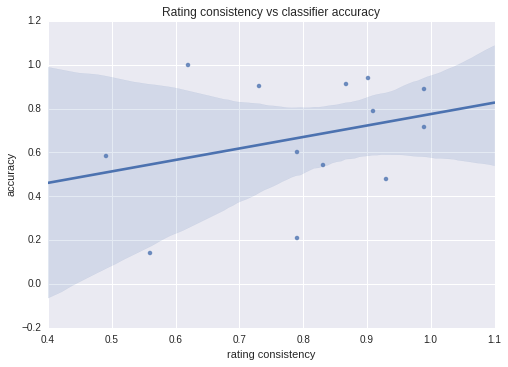

In [14]:
sns.regplot(consistency,cvdf.accuracy)
plt.title('Rating consistency vs classifier accuracy')
print 'r = %f' % consistency.corr(cvdf.accuracy)

However, rating consistency is clearly not the only factor affecting the accuracy of the classifier on different domains. For example, <code>rhapsody.com</code> has a very high consistency score (~0.99) and a very low accuracy (~0.58). Examining the source code of some actionable pages on <code>rhapsody.com</code> reveals that the "play" buttons are constructed in such a way that present method doesn't detect their text:

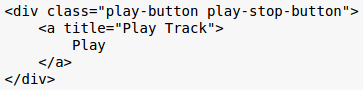

In [15]:
Image(filename="rhapsody_button.png")

This should be easily accounted for by extracting the text from children of button-like HTML elements.

Another domain on which the classifier fails is <code>seatgeek.com</code>. The buttons for searching for tickets on this site generally have text of the form "FROM $x":

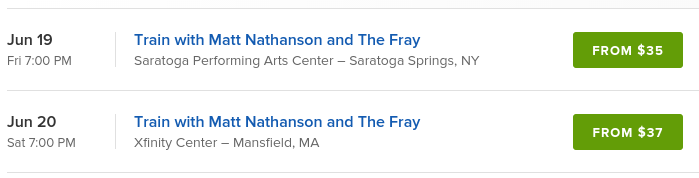

In [16]:
Image(filename="train_tickets.png")

The human viewer understands from context that these are to be read as "TICKETS FROM $35" and so on, but this classifier apparently does not. To deal with pages like this, we may need to construct features that don't depend on the textual content of the buttons, instead using structural features like link density. Preliminary efforts along these lines have yet to pan out.